# Epigenetic Clock Predict Biological Age by GEO Dataset

## Import Necessary Packages and Libraries

In [1]:
import biolearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import anndata as ad

from biolearn.data_library import DataLibrary
from biolearn.model_gallery import ModelGallery

## Load GEO Dataset from Biolearn and Preprocess Data for UMAP Plot

In [2]:

geo = DataLibrary().get("GSE40279")
gse40279 = geo.load()  # GeoData object

# Extract beta values and metadata
beta = gse40279.dnam          # CpGs x Samples
meta = gse40279.metadata       # Samples x metadata

# Transpose so samples = rows, CpGs = columns
beta_T = beta.T
beta_T.columns = beta_T.columns.astype(str)
meta.index = meta.index.astype(str)

# Create AnnData
adata = ad.AnnData(
    X=beta_T.values,
    obs=meta.reset_index(drop=True),
    var=pd.DataFrame(index=beta_T.columns)
)

# Ensure age column is numeric
adata.obs["age"] = adata.obs["age"].astype(float)

print("AnnData object ready:")
print(adata)
print(adata.obs.head())



AnnData object ready:
AnnData object with n_obs × n_vars = 656 × 473034
    obs: 'age', 'sex', 'ethnicity', 'tissue'
    age  sex             ethnicity       tissue
0  67.0    1  Caucasian - European  whole blood
1  89.0    1  Caucasian - European  whole blood
2  66.0    1  Caucasian - European  whole blood
3  64.0    1  Caucasian - European  whole blood
4  62.0    1  Caucasian - European  whole blood


/Users/sanzidaakhteranee/biolearn_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Apply Biolearn epigenetic clock (Horvathv1)


In [3]:
mg = ModelGallery()
clock = mg.get("Horvathv1")

# Pass GeoData object, not AnnData
pred = clock.predict(gse40279)
# Add predicted DNAmAge to AnnData
adata.obs["DNAmAge"] = pred["Predicted"].values



# UMAP Visualization of DNA Methylation Colored by DNAmAge


Python(77818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/sanzidaakhteranee/biolearn_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Python(77821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


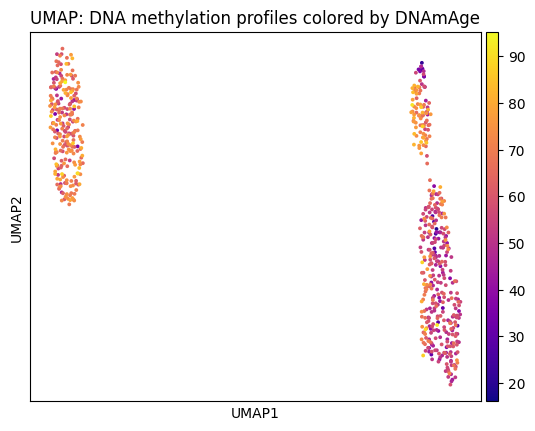

In [4]:

sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["DNAmAge"],
    cmap="plasma",
    size=30,
    title="UMAP: DNA methylation profiles colored by DNAmAge"
)



# Delta Beta (Δβ) Plot Highlighting Epigenetic Changes with Aging


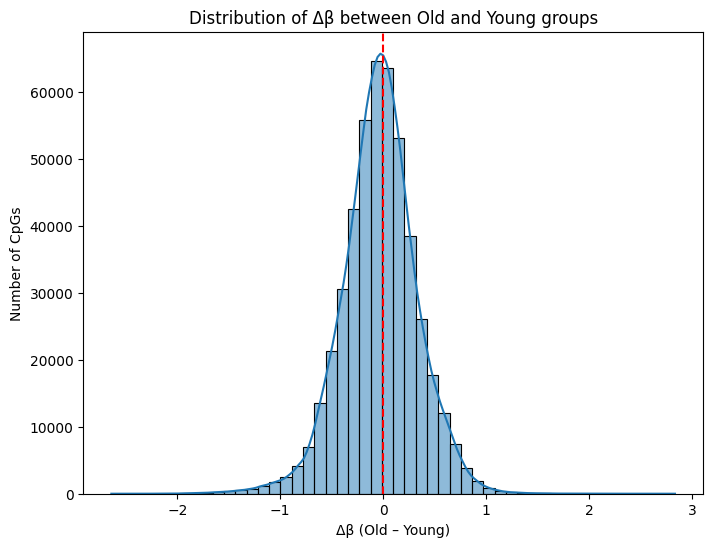

In [5]:
#β (Delta Beta) for young vs old groups
# Define groups by chronological age
young_idx = adata.obs["age"] < 40
old_idx   = adata.obs["age"] > 70

beta_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

mean_young = beta_df.loc[young_idx].mean(axis=0)
mean_old   = beta_df.loc[old_idx].mean(axis=0)

delta_beta = mean_old - mean_young
delta_df = pd.DataFrame({"CpG": beta_df.columns, "DeltaBeta": delta_beta})
delta_df["abs_db"] = delta_df["DeltaBeta"].abs()
delta_df = delta_df.sort_values("abs_db", ascending=False).drop(columns="abs_db")

# Histogram of Δβ
plt.figure(figsize=(8,6))
sns.histplot(delta_df["DeltaBeta"], bins=50, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Δβ (Old – Young)")
plt.ylabel("Number of CpGs")
plt.title("Distribution of Δβ between Old and Young groups")
plt.show()


# Lolipop Plot for Top CpGs

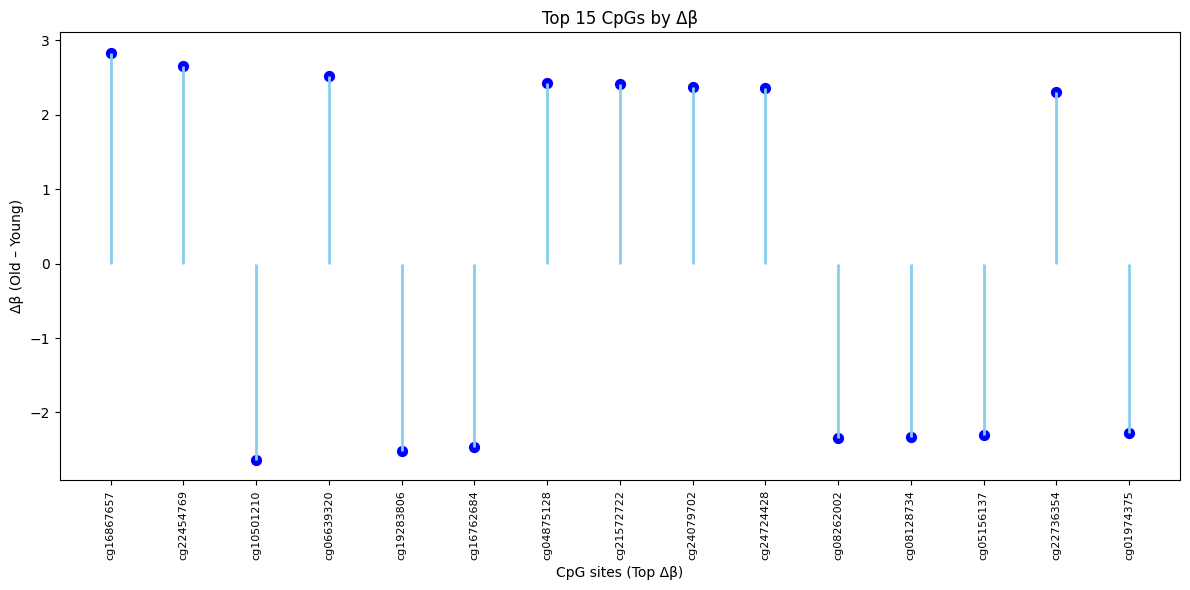

In [6]:

top_n = 15
top = delta_df.head(top_n).copy()

plt.figure(figsize=(12,6))
plt.vlines(x=range(top_n), ymin=0, ymax=top["DeltaBeta"], color='skyblue', linewidth=2)
plt.scatter(range(top_n), top["DeltaBeta"], color='blue', s=50)
plt.xticks(range(top_n), top["CpG"], rotation=90, fontsize=8)
plt.xlabel("CpG sites (Top Δβ)")
plt.ylabel("Δβ (Old – Young)")
plt.title(f"Top {top_n} CpGs by Δβ")
plt.tight_layout()
plt.show()
